# V3 : ML Height prediction

In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
import rasterio
import numpy as np
import pickle
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import shapely
from to_degree import to_degree
from region_new import Region
from region_new.emission import *

In [2]:
# bounding boxes and FUA's
bounding_box = json.load(open('bounding_box.json'))

In [3]:
height_path = os.path.join('data', 'ghsl', 'height', '')
height_pred_path = os.path.join('data', 'ml', 'prediction', 'height', '')

In [4]:
# johannesburg_house = os.path.join("data","microsoft_buildings","Johannesburg.json")
# cairo_house = os.path.join("data","microsoft_buildings","Cairo.json")
turkey_path = os.path.join("data", "ml", "datasets", "Turkey.pkl")
with open(turkey_path,"rb") as f:
    turkey_house = pickle.load(f)

In [5]:
cities = dict(
    Ordu = dict (
        box= bounding_box['Ordu']['box'],
        fua= bounding_box['Ordu']['fua'],
        name= 'Ordu',
        house= turkey_house[turkey_house.city=='Ordu']
    ),
    Adana = dict(
        box= bounding_box["Adana"]["box"],
        fua= bounding_box["Adana"]["fua"],
        name = "Adana",
        house = turkey_house[turkey_house.city=='Adana']
    ),
    Manisa = dict(
        box= bounding_box["Manisa"]["box"],
        fua= bounding_box["Manisa"]["fua"],
        name = "Manisa",
        house = turkey_house[turkey_house.city=='Manisa']
    ),
    Trabzon = dict(
        box= bounding_box["Trabzon"]["box"],
        fua= bounding_box["Trabzon"]["fua"],
        name = "Trabzon",
        house = turkey_house[turkey_house.city=='Trabzon']
    )
)

In [7]:
# Reproject GHSL Data into EPSG:4326
to_degree(height_path, cities)

In [8]:
to_degree(height_pred_path, cities)

In [7]:
Cities = {}
resolution = (-500, 500)
# resolution = (-100, 100)
for index, (key, val) in enumerate(cities.items()):
    print(key)
    box, fua, name, house = val["box"], val["fua"], val["name"], val["house"]
    city = Region(val["box"])


    # Parse FUA edges from JSON
    fua = shapely.geometry.Polygon(fua)
    fua = geopandas.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[fua])
    # FUA edges
    city.add_layer(layer_name="fua", 
                   geo_data=fua, 
                   layer_type="vector", 
                   box=box, 
                   meta="Functional Urban Area")
    
    # MS building
    
    city.add_layer(layer_name="MS", 
                   geo_data=house, 
                   layer_type="vector", 
                   meta="MS buildings")
   
    # Rasters

    city.add_layer(layer_name="height", 
                   geo_data=height_path+name+'.tif', 
                   layer_type="raster", 
                   box=box, 
                   var_name="height", 
                   meta="GHSL BUILT-H")
    
    city.add_layer(
        layer_name='height_pred',
        geo_data=height_pred_path+name+'.tif',
        layer_type='raster',
        box=box,
        var_name='height_pred',
        meta='predicted height'
    )
    # convert vector to raster
    city.add_raster_from_vector(layer_name="MS", 
                                measurements=["area","density"], 
                                resolution=resolution, 
                                new_name = "MS_raster",
                                res_type="meter")
    # unify the projection
    city.unify_proj(crs_type="meter")
    
    # merge raster as output xarray
    city.merge_data(base_raster="MS_raster", 
                    raster_list={
                        "height":(["height"], "linear"),
                        "height_pred":(["height_pred"], "linear")
                        }
                    )
    
    # estimate co2 emission with simple function
    city.output = city.output.assign(emission = emission_height_prediction)
    Cities[key] = city           
    print(city.output)                                                                       

Ordu
<xarray.Dataset>
Dimensions:      (x: 46, y: 32, band: 1)
Coordinates:
  * x            (x) float64 4.207e+06 4.208e+06 ... 4.229e+06 4.23e+06
  * y            (y) float64 4.988e+06 4.988e+06 ... 4.973e+06 4.973e+06
    spatial_ref  int64 0
  * band         (band) int64 1
Data variables:
    area         (y, x) float64 2.812e+03 1.325e+04 522.9 0.0 ... 0.0 0.0 0.0
    density      (y, x) float64 6.0 27.0 2.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    height       (band, y, x) float64 0.0 0.0 0.4539 0.005987 ... 0.0 0.0 0.0
    height_pred  (band, y, x) float64 0.0 0.0 0.003697 0.0 ... nan nan nan nan
    emission     (y, x, band) float64 0.0 0.0 3.866 0.0 0.0 ... nan nan nan nan
Adana
<xarray.Dataset>
Dimensions:      (x: 85, y: 40, band: 1)
Coordinates:
  * x            (x) float64 3.906e+06 3.906e+06 ... 3.947e+06 3.948e+06
  * y            (y) float64 4.423e+06 4.422e+06 ... 4.404e+06 4.403e+06
    spatial_ref  int64 0
  * band         (band) int64 1
Data variables:
    area      

In [8]:
# dump city
dump_path = os.path.join("data","Cities_v3_1_comparison.pickle")
with open(dump_path,"wb") as f:
    pickle.dump(Cities, f, protocol=pickle.HIGHEST_PROTOCOL)

## RESULTS

In [9]:
# load city
dump_path = os.path.join("data","Cities_v3_1_comparison.pickle")
with open(dump_path, 'rb') as f:
    Cities = pickle.load(f)

In [10]:
# cairo = Cities['Cairo']
# adana = Cities['Adana']
# johannesburg = Cities['Johannesburg']
ordu = Cities['Ordu']
manisa = Cities['Manisa']
adana = Cities['Adana']
trabzon = Cities['Trabzon']

### ADANA

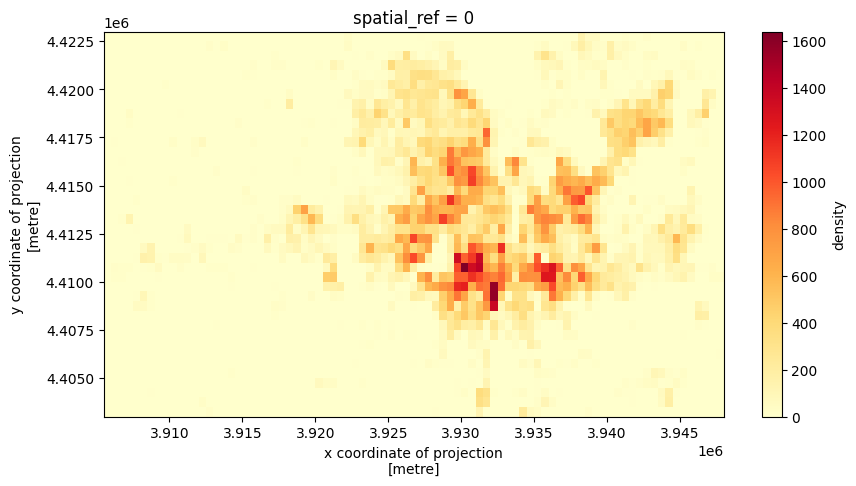

In [11]:
# BUILDING DENSITY
adana.output.density.plot(cmap="YlOrRd", figsize=(10,5))

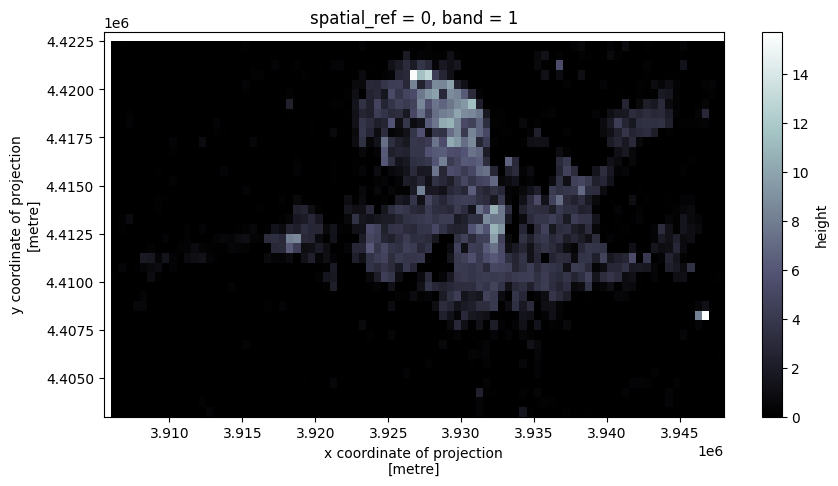

In [12]:
# BUILDING HEIGHT
adana.output.height.plot(cmap="bone", figsize=(10,5))

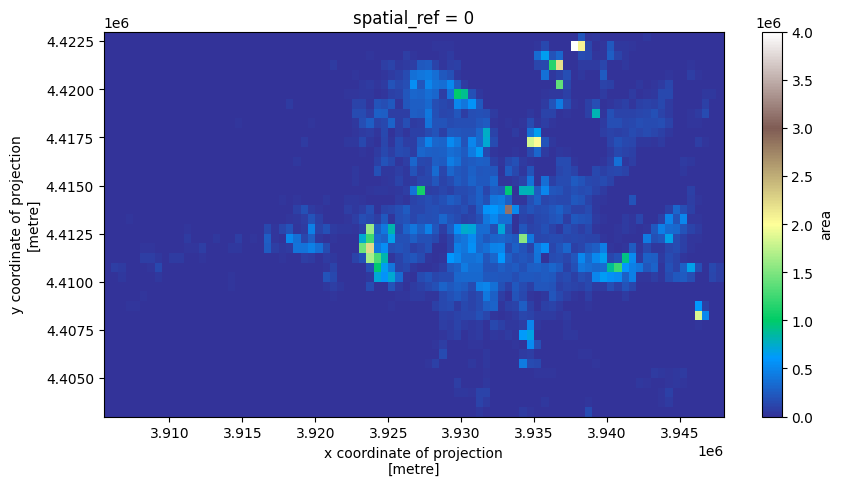

In [13]:
# AREA
adana.output.area.plot(cmap='terrain', figsize=(10,5))

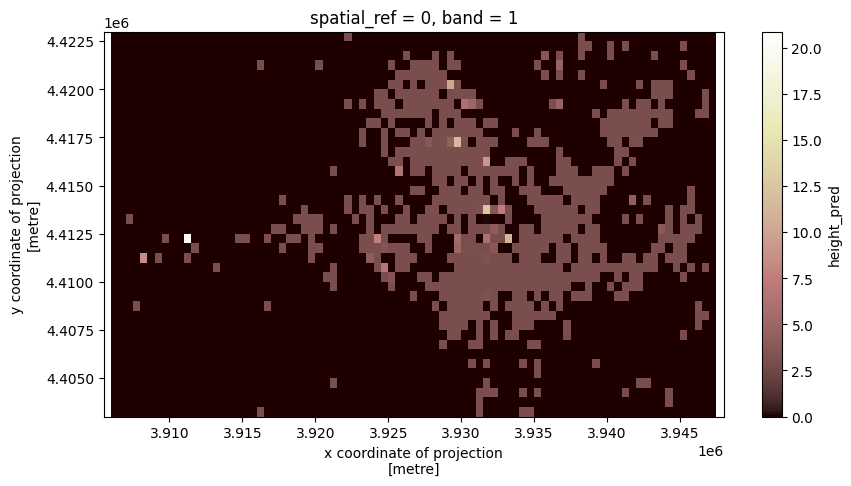

In [14]:
adana.output.height_pred.plot(cmap="pink",figsize=(10,5))

#### Some illustrative difference map :
    - GHSL height vs our height prediction

In [15]:
adana.normalize_output()
ordu.normalize_output()
manisa.normalize_output()
trabzon.normalize_output()

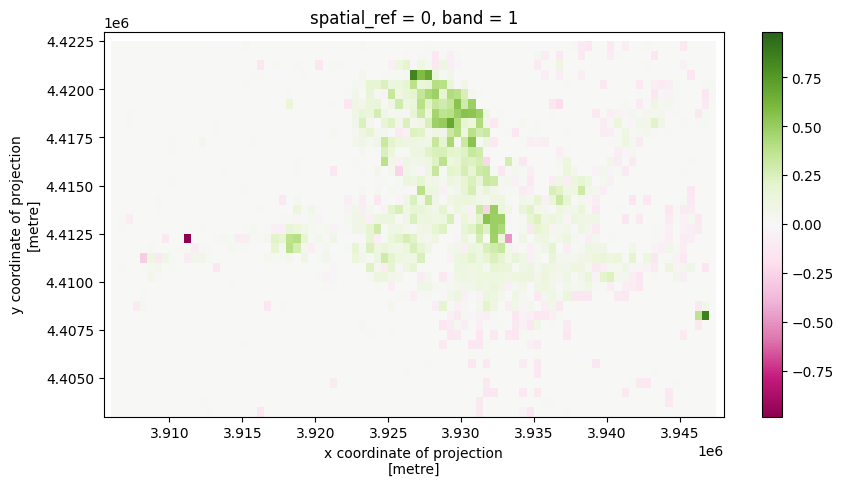

In [16]:
adana.difference_map('height', 'height_pred')


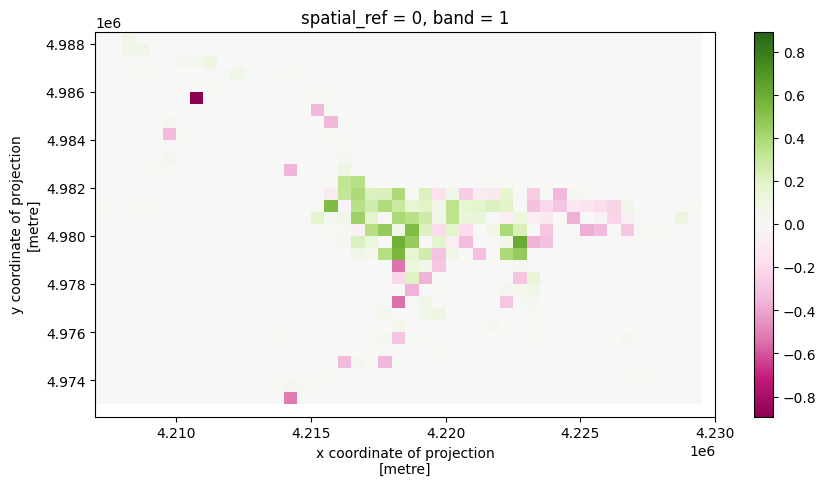

In [17]:
ordu.difference_map('height', 'height_pred')

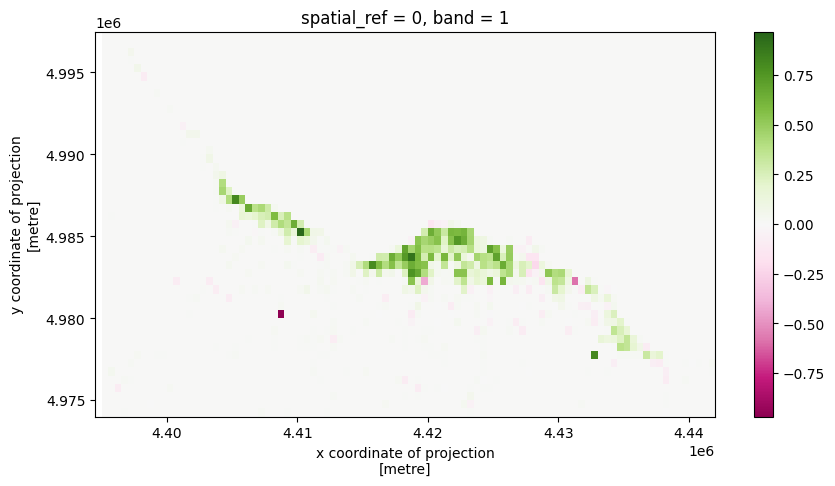

In [18]:
trabzon.difference_map('height', 'height_pred')

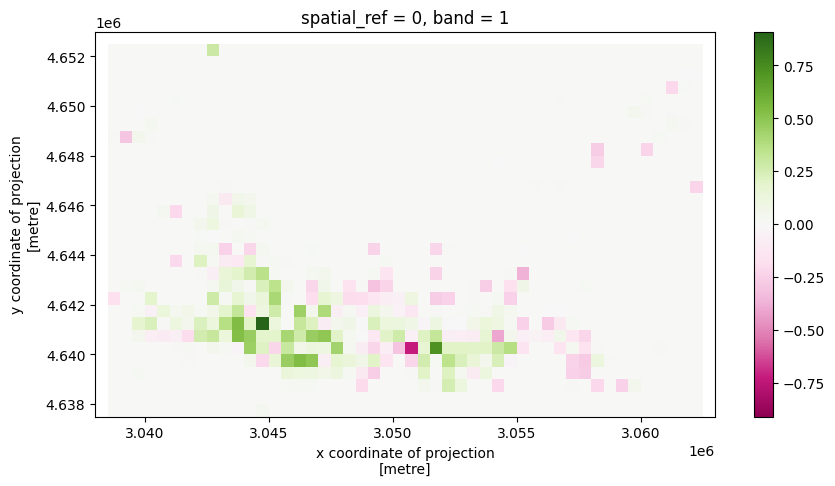

In [19]:
manisa.difference_map('height', 'height_pred')

We underestimate height compared to the GHSL estimations

In [20]:
import rioxarray

In [22]:
v2_path = os.path.join('data', 'results', 'adana.tif')
v2_emission = rioxarray.open_rasterio(v2_path)

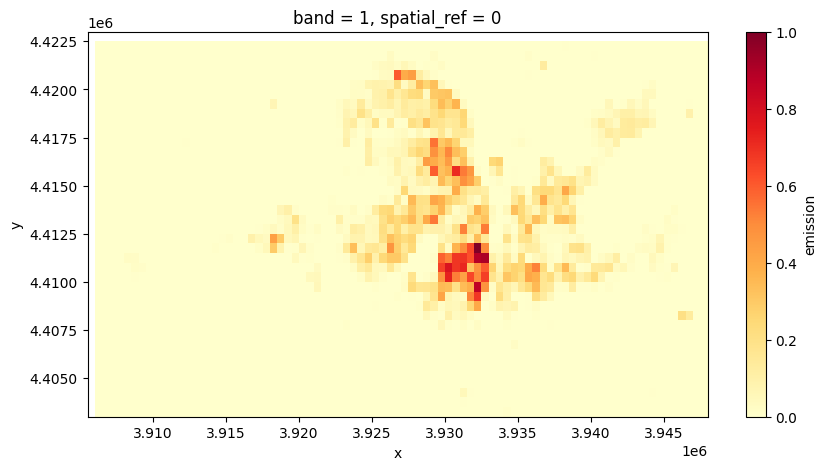

In [25]:
v2_emission.plot(cmap='YlOrRd', figsize=(10,5))

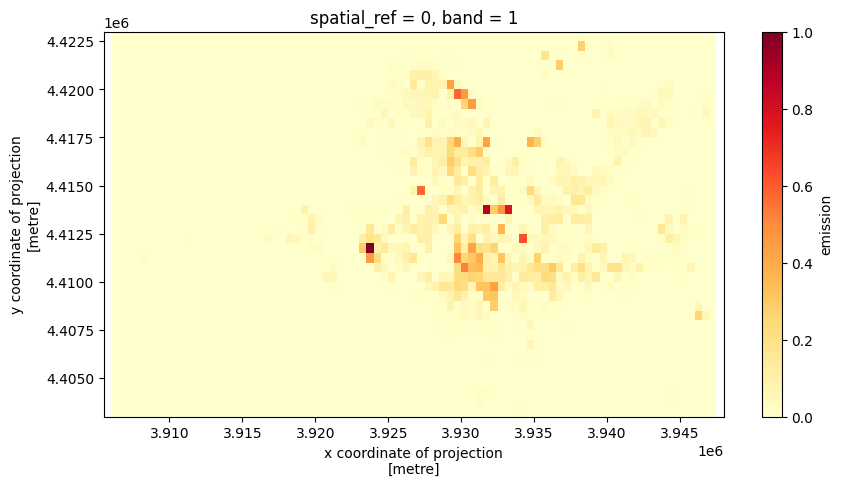

In [28]:
adana.output.emission.plot(cmap='YlOrRd', figsize=(10,5))